# Research Question 2

Is it possible to predict the success of future instalments of a movie/game?\
Does the failure of an initial movie/game indicate commercial failures of subsequent ones? Can a franchise recover from a flop?


In [84]:
import pandas as pd
import ast
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap

In [44]:
pd.set_option("display.max_columns", None)

In [45]:
df = pd.read_csv("franchises_combined_by_year.csv", index_col = 0)

In [46]:
df = df.groupby('franchise_id').agg(min_year=('year', 'min'), max_year=('year', 'max')) \
       .reset_index() \
       .merge(df, on='franchise_id', how='right') \
       .assign(position_in_franchise=lambda x: (x['year'] - x['min_year']) / (x['max_year'] - x['min_year']) * 100)

In [47]:
df = df.groupby('franchise_id').agg(min_vote=('votes_average', 'min'), max_vote=('votes_average', 'max')) \
       .reset_index() \
       .merge(df, on='franchise_id', how='right')


In [48]:
df = df.groupby('franchise_id').agg(min_rating=('rating_average', 'min'), max_rating=('rating_average', 'max')) \
       .reset_index() \
       .merge(df, on='franchise_id', how='right')

In [49]:
idx = df.groupby('franchise_id')['rating_average'].idxmin()

# Select the year value at the index and assign it to a new column for every row with the same franchise_id
df['lowest_rated_year'] = df.loc[idx, 'year'].values.repeat(df.groupby('franchise_id').size())
df['lowest_rated_pos'] = df.loc[idx, 'position_in_franchise'].values.repeat(df.groupby('franchise_id').size())

In [50]:
df["pos_rel_to_lowest_year"] = df.apply(lambda x: 'pre' if x['year'] < x['lowest_rated_year'] else ('post' if x['year'] > x['lowest_rated_year'] else 'lowest'), axis=1)

In [51]:
df['avg_pre_rating'] = df.groupby('franchise_id')['rating_average'].transform(lambda x: x.loc[df['pos_rel_to_lowest_year'] == 'pre'].mean())
df['avg_post_rating'] = df.groupby('franchise_id')['rating_average'].transform(lambda x: x.loc[df['pos_rel_to_lowest_year'] == 'post'].mean())

In [52]:
df.avg_pre_rating.value_counts()

7.100000    135
7.500000    126
7.800000    125
7.700000    120
6.800000    113
           ... 
5.433333      2
8.900000      2
8.250000      2
3.800000      2
6.900000      2
Name: avg_pre_rating, Length: 607, dtype: int64

In [53]:
df = df.groupby('franchise_id').apply(lambda x: x.assign(diff_between_pre_and_lowest = x['min_rating'] - x['avg_pre_rating'])).reset_index(level=0, drop=True)
df = df.groupby('franchise_id').apply(lambda x: x.assign(diff_between_post_and_lowest = x['avg_post_rating'] - x['min_rating'])).reset_index(level=0, drop=True)

We can get the average difference in rating when a subsequent release is rated lower.

In [54]:
df['rolling_mean'] = df.groupby('franchise_id')['rating_average'].expanding().mean().reset_index(0, drop=True)
df['diff_from_rolling_mean']= df.groupby('franchise_id')['rolling_mean'].diff()

In [55]:
df[df['diff_between_post_and_lowest'] < -df['diff_between_pre_and_lowest']].franchise_id.nunique()

569

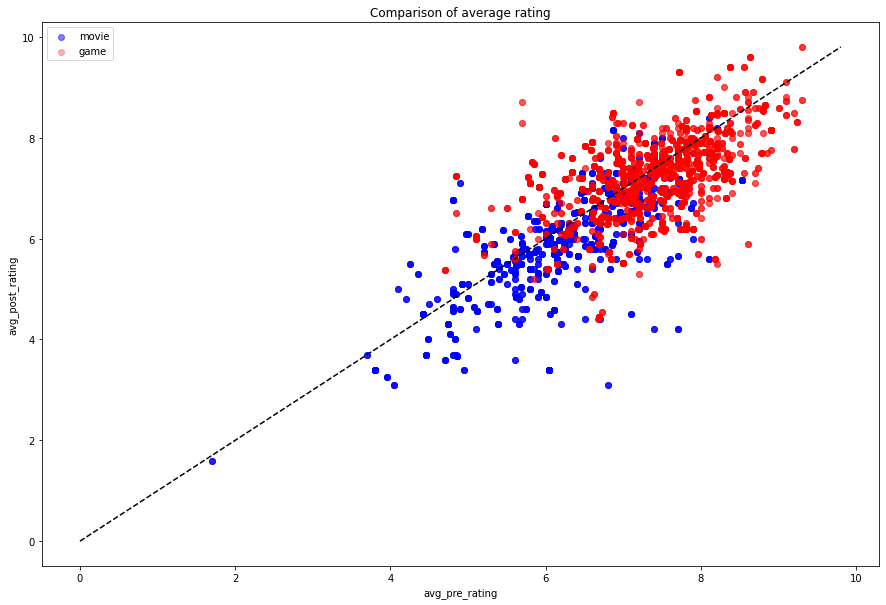

In [56]:
fig, ax = plt.subplots(figsize=(15, 10))

# create separate dataframes for movie and game content types
df_movie = df[df['type'] == 'movie']
df_game = df[df['type'] == 'game']

# plot movie data as blue scatter plot
plt.scatter(df_movie['avg_pre_rating'], df_movie['avg_post_rating'], c='blue', label='movie', alpha = 0.5)

# plot game data as red scatter plot
plt.scatter(df_game['avg_pre_rating'], df_game['avg_post_rating'], c='red', label='game', alpha = 0.3)

# draw a diagonal line from the origin
max_val = max(df['avg_pre_rating'].max(), df['avg_post_rating'].max())
plt.plot([0, max_val], [0, max_val], 'k--')

# set the x and y axis labels
plt.title('Comparison of average rating')
plt.xlabel('avg_pre_rating',)
plt.ylabel('avg_post_rating')

# set legend
plt.legend()

# show the plot
plt.show()


In [57]:
df[df["franchise_id"] == '3025-1889']['diff_between_pre_and_lowest']

1829   -3.1
1830   -3.1
1831   -3.1
1832   -3.1
Name: diff_between_pre_and_lowest, dtype: float64

In [58]:
df_movie.franchise_count[7305]

11.0

In [59]:
df_movie

,franchise_id,min_rating,max_rating,min_vote,max_vote,min_year,max_year,franchise_name,type,tconst,title,year,is_adult,runtime,genres,votes_average,rating_average,franchise_count,content_per_year,year_diff,vote_diff,rating_diff,num_of_releases_diff,z_rating,z_votes,position_in_franchise,lowest_rated_year,lowest_rated_pos,pos_rel_to_lowest_year,avg_pre_rating,avg_post_rating,diff_between_pre_and_lowest,diff_between_post_and_lowest,rolling_mean,diff_from_rolling_mean
7305,f0,6.00,7.7,49.0,146.0,1939,1944,The Aldrich Family,movie,tt0032123,what a life,1939,0,75,"['Drama', 'Comedy']",93.000000,6.90,11.0,1.0,NaN,NaN,NaN,NaN,0.770287,-0.344004,0.000000,1940,20.0,pre,6.9,7.025,-0.9,1.025,6.900000,NaN
7306,f0,6.00,7.7,49.0,146.0,1939,1944,The Aldrich Family,movie,tt0033834,life with henry,1940,0,80,"['Music', 'Family', 'Comedy']",49.000000,6.00,11.0,1.0,1.0,-44.000000,-0.90,0.0,-0.016976,-0.344236,20.000000,1940,20.0,lowest,6.9,7.025,-0.9,1.025,6.450000,-0.450000
7307,f0,6.00,7.7,49.0,146.0,1939,1944,The Aldrich Family,movie,tt0033708,henry aldrich for president,1941,0,75,"['Family', 'Comedy']",146.000000,6.60,11.0,1.0,1.0,97.000000,0.60,0.0,0.507866,-0.343725,40.000000,1940,20.0,post,6.9,7.025,-0.9,1.025,6.500000,0.050000
7308,f0,6.00,7.7,49.0,146.0,1939,1944,The Aldrich Family,movie,"tt0034842, tt0034844","henry aldrich, editor, henry and dizzy",1942,0,72,"['Family', 'Drama', 'Comedy']",104.000000,6.80,11.0,2.0,1.0,-42.000000,0.20,1.0,0.682813,-0.343946,60.000000,1940,20.0,post,6.9,7.025,-0.9,1.025,6.575000,0.075000
7309,f0,6.00,7.7,49.0,146.0,1939,1944,The Aldrich Family,movie,"tt0035985, tt0035983, tt0035984","henry aldrich swings it, henry aldrich gets gl...",1943,0,64,"['Adventure', 'Family', 'Comedy']",130.333333,7.00,11.0,3.0,1.0,26.333333,0.20,1.0,0.857760,-0.343808,80.000000,1940,20.0,post,6.9,7.025,-0.9,1.025,6.660000,0.085000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10982,f994,6.40,7.0,99.0,658.0,1948,1952,Renato Castellani's Italian neorealism trilogy,movie,tt0040018,it's forever springtime,1950,0,92,"['Drama', 'Comedy']",99.000000,6.40,3.0,1.0,2.0,-212.000000,-0.50,0.0,0.332918,-0.343973,50.000000,1950,50.0,lowest,6.9,7.000,-0.5,0.600,6.650000,-0.250000
10983,f994,6.40,7.0,99.0,658.0,1948,1952,Renato Castellani's Italian neorealism trilogy,movie,tt0044572,two cents worth of hope,1952,0,110,"['Romance', 'Comedy']",658.000000,7.00,3.0,1.0,2.0,559.000000,0.60,0.0,0.857760,-0.341028,100.000000,1950,50.0,post,6.9,7.000,-0.5,0.600,6.766667,0.116667
10984,f995,4.25,5.2,2068.0,5449.5,1974,1987,It's Alive,movie,"tt0071198, tt0071675","the bat people, it's alive",1974,0,93,"['Horror', 'Sci-Fi', 'Romance']",5449.500000,4.25,4.0,2.0,NaN,NaN,NaN,NaN,-1.547765,-0.315787,0.000000,1974,0.0,lowest,NaN,5.000,NaN,0.750,4.250000,NaN
10985,f995,4.25,5.2,2068.0,5449.5,1974,1987,It's Alive,movie,tt0077756,it lives again,1978,0,91,"['Horror', 'Sci-Fi']",2494.000000,5.20,4.0,1.0,4.0,-2955.500000,0.95,-1.0,-0.716766,-0.331356,30.769231,1974,0.0,post,NaN,5.000,NaN,0.750,4.725000,0.475000


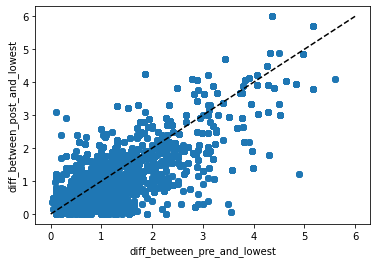

In [60]:
plt.scatter(-df['diff_between_pre_and_lowest'], df['diff_between_post_and_lowest'])

# draw a diagonal line from the origin
plt.plot([0, max(df['diff_between_pre_and_lowest'].max(), df['diff_between_post_and_lowest'].max())], [0, max(df['diff_between_pre_and_lowest'].max(), df['diff_between_post_and_lowest'].max())], 'k--')

# set the x and y axis labels
plt.xlabel('diff_between_pre_and_lowest')
plt.ylabel('diff_between_post_and_lowest')

# show the plot
plt.show()

In [61]:
df.sort_values('diff_from_rolling_mean').head(50)

,franchise_id,min_rating,max_rating,min_vote,max_vote,min_year,max_year,franchise_name,type,tconst,title,year,is_adult,runtime,genres,votes_average,rating_average,franchise_count,content_per_year,year_diff,vote_diff,rating_diff,num_of_releases_diff,z_rating,z_votes,position_in_franchise,lowest_rated_year,lowest_rated_pos,pos_rel_to_lowest_year,avg_pre_rating,avg_post_rating,diff_between_pre_and_lowest,diff_between_post_and_lowest,rolling_mean,diff_from_rolling_mean
6790,3025-816,2.20,7.80,11.0,27.000000,2005,2015,America's Army,game,tt1090640,America's Army: True Soldiers,2007,0,NaN,"['Action', ' Shooter']",25.0,2.20,3.0,1.0,2.0,-2.0,-5.60,0.0,-4.551525,-0.248558,20.000000,2007,20.000000,lowest,7.800000,6.300000,-5.600000,4.100000,5.000000,-2.800000
10764,f895,1.90,6.80,38.0,2330.000000,2011,2013,Evil Born,movie,tt2313780,12/12/12,2012,0,86,['Horror'],1620.0,1.90,3.0,1.0,1.0,1582.0,-4.90,0.0,-3.603396,-0.335960,50.000000,2012,50.000000,lowest,6.800000,3.100000,-4.900000,1.200000,4.350000,-2.450000
1795,3025-1866,2.50,7.40,8.0,66.000000,1985,2013,The Wizard of Oz,game,tt2887448,The Wizard of Oz,1993,0,NaN,"['Adventure', ' Fantasy']",37.0,2.50,3.0,1.0,8.0,29.0,-4.50,0.0,-4.272887,-0.243469,28.571429,1993,28.571429,lowest,7.000000,7.400000,-4.500000,4.900000,4.750000,-2.250000
4297,3025-409,3.10,8.10,9.0,1127.000000,1995,2019,Rayman,game,tt8535032,Rayman Brain Games,1996,0,NaN,"['Family', ' Educational']",9.0,3.10,16.0,1.0,1.0,-753.0,-4.40,0.0,-3.715611,-0.255343,4.166667,1996,4.166667,lowest,7.500000,6.925000,-4.400000,3.825000,5.300000,-2.200000
8621,f173,3.80,8.10,12172.0,417943.000000,1973,2005,The Exorcist,movie,tt0076009,exorcist ii: the heretic,1977,0,117,['Horror'],25719.0,3.80,5.0,1.0,4.0,-392224.0,-4.30,0.0,-1.941397,-0.209009,12.500000,1977,12.500000,lowest,8.100000,5.600000,-4.300000,1.800000,5.950000,-2.150000
10729,f882,3.40,7.30,40755.0,394057.000000,1994,2014,Dumb and Dumber,movie,tt0329028,dumb and dumberer: when harry met lloyd,2003,0,85,['Comedy'],40755.0,3.40,3.0,1.0,9.0,-353302.0,-3.90,0.0,-2.291292,-0.129800,45.000000,2003,45.000000,lowest,7.300000,5.600000,-3.900000,2.200000,5.350000,-1.950000
501,3025-1203,3.70,7.50,6.0,669.000000,1983,2002,Dragon's Lair,game,tt3034468,Dragon's Lair,1990,0,NaN,"[' Adventure', 'Puzzle']",49.0,3.70,5.0,1.0,7.0,-620.0,-3.80,0.0,-3.158335,-0.238381,36.842105,1990,36.842105,lowest,7.500000,6.333333,-3.800000,2.633333,5.600000,-1.900000
10686,f865,3.90,7.40,4266.0,16869.000000,2007,2019,Dhamaal,movie,tt1728239,double dhamaal,2011,0,138,"['Crime', 'Drama', 'Comedy']",4266.0,3.90,3.0,1.0,4.0,-12603.0,-3.50,0.0,-1.853923,-0.322021,33.333333,2011,33.333333,lowest,7.400000,4.200000,-3.500000,0.300000,5.650000,-1.750000
9212,f377,2.10,5.55,158.5,169.000000,1968,1971,Journey to the Unknown,movie,tt0329247,journey to murder,1971,0,100,"['Horror', 'Mystery', 'Drama']",169.0,2.10,3.0,1.0,3.0,10.5,-3.45,-1.0,-3.428449,-0.343604,100.000000,1971,100.000000,lowest,5.550000,NaN,-3.450000,NaN,3.825000,-1.725000
3250,3025-3009,5.50,8.90,6.0,105.000000,2013,2018,Galapagos RPG,game,tt3880680,Omega Quintet,2014,0,NaN,"[' Role-Playing', '\\\\N']",11.0,5.50,4.0,1.0,1.0,-92.0,-3.40,0.0,-1.486507,-0.254494,20.000000,2014,20.000000,lowest,8.900000,7.750000,-3.400000,2.250000,7.200000,-1.700000


<AxesSubplot:>

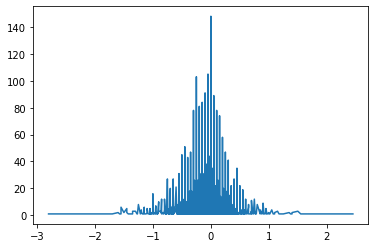

In [62]:
df.diff_from_rolling_mean.value_counts().sort_index().plot()

In [63]:
df[df['rating_diff'] < 0].rating_diff.describe()

count    4.841000e+03
mean    -8.367262e-01
std      7.473222e-01
min     -6.700000e+00
25%     -1.150000e+00
50%     -6.000000e-01
75%     -3.000000e-01
max     -8.881784e-16
Name: rating_diff, dtype: float64

In [64]:
franchise_grouped_df = df.groupby('franchise_id').agg(    
    franchise_name = ('franchise_name', 'last'),
    total_running_length_years=('year', lambda x: (x.max() - x.min()) +1),
    releases_in_franchise=('franchise_count', 'max'),
    content_type = ('type', 'last'),
    avg_pre_rating = ('avg_pre_rating', 'last'),
    average_rating = ('rating_average', 'mean'),
    lowest_rating = ('min_rating', 'first'),
    avg_post_rating = ('avg_post_rating', 'last'),
    average_votes = ('votes_average', 'mean'),
    lowest_rated_year = ('lowest_rated_year', 'last'),
    pos_in_fran_lowest_rated = ('lowest_rated_pos', 'last'),
    diff_between_post_and_lowest = ('diff_between_post_and_lowest', 'last'),
    diff_between_pre_and_lowest = ('diff_between_pre_and_lowest', 'last')
)

In [65]:
franchise_grouped_df['diff_pre_vs_post'] = franchise_grouped_df.apply(lambda x: x['avg_post_rating'] - x['avg_pre_rating'], axis = 1)

In [66]:
franchise_grouped_df['diff_between_pre_and_lowest'] = franchise_grouped_df['diff_between_pre_and_lowest'].apply(lambda x: 0 if pd.isna(x) else abs(x))

In [67]:
franchise_grouped_df['diff_lowest_vs_avg'] = franchise_grouped_df['average_rating'] - franchise_grouped_df['lowest_rating']

In [68]:
franchise_grouped_df

,franchise_name,total_running_length_years,releases_in_franchise,content_type,avg_pre_rating,average_rating,lowest_rating,avg_post_rating,average_votes,lowest_rated_year,pos_in_fran_lowest_rated,diff_between_post_and_lowest,diff_between_pre_and_lowest,diff_pre_vs_post,diff_lowest_vs_avg
franchise_id,,,,,,,,,,,,,,,
3025-1,Mario,45,195.0,game,NaN,6.800734,3.000000,6.891227,750.130888,1978,0.000000,3.891227,0.000000,NaN,3.800734
3025-10,Tony Hawk,22,15.0,game,6.866667,6.671429,2.500000,8.500000,601.107143,2015,76.190476,6.000000,4.366667,1.633333,4.171429
3025-100,Commander Keen,12,8.0,game,NaN,7.080556,6.866667,7.187500,69.805556,1990,0.000000,0.320833,0.000000,NaN,0.213889
3025-1000,Fate,22,10.0,game,7.700000,7.590000,7.100000,7.637500,51.800000,2005,23.809524,0.537500,0.600000,-0.062500,0.490000
3025-1008,Winx Club,9,6.0,game,7.550000,7.590000,7.100000,8.200000,11.500000,2012,75.000000,1.100000,0.450000,0.650000,0.490000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
f99,The Conjuring Universe,9,8.0,movie,6.675000,6.264286,5.300000,5.925000,205675.000000,2018,62.500000,0.625000,1.375000,-0.750000,0.964286
f990,Inspector Hornleigh,3,3.0,movie,6.750000,6.725000,6.700000,NaN,258.000000,1941,100.000000,NaN,0.050000,NaN,0.025000
f993,I soliti ignoti,28,3.0,movie,7.450000,6.766667,5.400000,NaN,4053.333333,1985,100.000000,NaN,2.050000,NaN,1.366667


In [69]:
# create separate dataframes for movie and game content types
franchise_grouped_df_movie = franchise_grouped_df[franchise_grouped_df['content_type'] == 'movie']
franchise_grouped_df_game = franchise_grouped_df[franchise_grouped_df['content_type'] == 'game']

<AxesSubplot:>

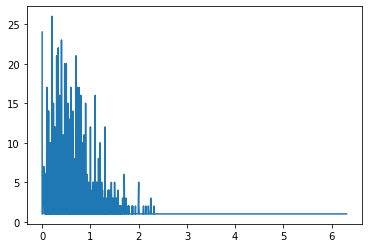

In [70]:
franchise_grouped_df.diff_lowest_vs_avg.value_counts().sort_index().plot()

<AxesSubplot:>

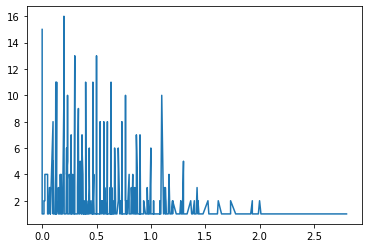

In [71]:
franchise_grouped_df_movie.diff_lowest_vs_avg.value_counts().sort_index().plot()

<AxesSubplot:>

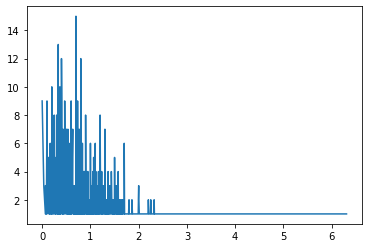

In [72]:
franchise_grouped_df_game.diff_lowest_vs_avg.value_counts().sort_index().plot()

In [73]:
franchise_grouped_df_movie_flops = franchise_grouped_df_movie[franchise_grouped_df_movie['diff_lowest_vs_avg'] > 1.5]
franchise_grouped_df_game_flops = franchise_grouped_df_game[franchise_grouped_df_game['diff_lowest_vs_avg'] > 2.5]

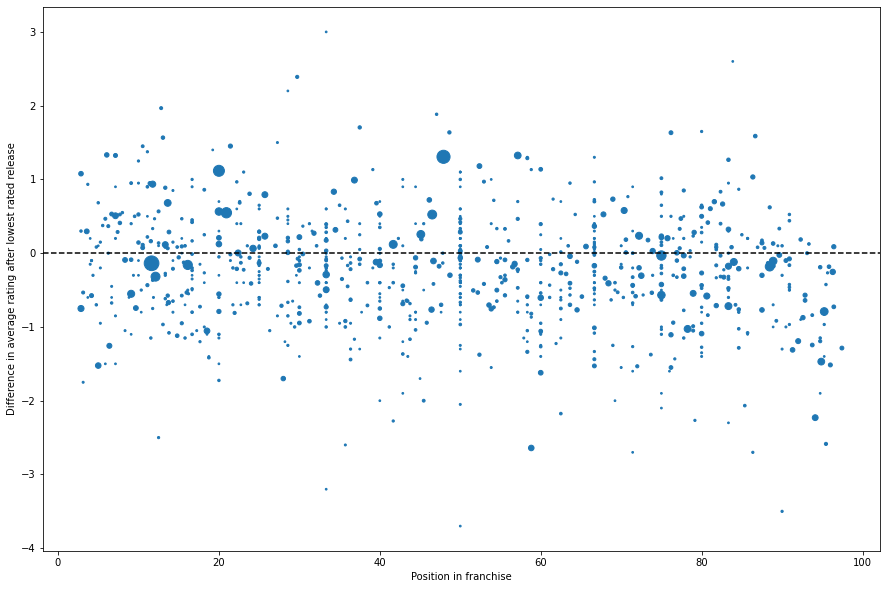

In [74]:
fig, ax = plt.subplots(figsize=(15, 10))
plt.scatter(y=franchise_grouped_df['diff_pre_vs_post'], x=franchise_grouped_df['pos_in_fran_lowest_rated'], s = franchise_grouped_df['releases_in_franchise'])
plt.axhline(y=0, linestyle='--', color='black')
plt.ylabel('Difference in average rating after lowest rated release')
plt.xlabel('Position in franchise')
#plt.xscale('log')
plt.show()


In [75]:
franchise_grouped_df_movie_flops.count()

franchise_name                  71
total_running_length_years      71
releases_in_franchise           71
content_type                    71
avg_pre_rating                  68
average_rating                  71
lowest_rating                   71
avg_post_rating                 29
average_votes                   71
lowest_rated_year               71
pos_in_fran_lowest_rated        71
diff_between_post_and_lowest    29
diff_between_pre_and_lowest     71
diff_pre_vs_post                26
diff_lowest_vs_avg              71
dtype: int64

In [76]:
franchise_grouped_df_movie[franchise_grouped_df_movie['avg_pre_rating'] == franchise_grouped_df_movie['avg_post_rating']]

,franchise_name,total_running_length_years,releases_in_franchise,content_type,avg_pre_rating,average_rating,lowest_rating,avg_post_rating,average_votes,lowest_rated_year,pos_in_fran_lowest_rated,diff_between_post_and_lowest,diff_between_pre_and_lowest,diff_pre_vs_post,diff_lowest_vs_avg
franchise_id,,,,,,,,,,,,,,,
f1050,Lucky Stars (Secondary Trilogy),7,3.0,movie,5.4,5.366667,5.30,5.4,227.666667,1989,50.000000,0.10,0.10,0.0,0.066667
f1092,My Wife Is a Gangster,6,3.0,movie,6.3,6.200000,6.00,6.3,2138.666667,2003,40.000000,0.30,0.30,0.0,0.200000
f1108,Noriko,5,3.0,movie,8.2,8.166667,8.10,8.2,30134.000000,1951,50.000000,0.10,0.10,0.0,0.066667
f1272,"Wally ""The Fox"" Benton",3,3.0,movie,6.7,6.633333,6.50,6.7,794.000000,1942,50.000000,0.20,0.20,0.0,0.133333
f776,BRD Trilogy,4,4.0,movie,7.7,7.450000,6.95,7.7,8320.666667,1981,66.666667,0.75,0.75,0.0,0.500000
f960,The Happy Hooker,6,3.0,movie,3.7,3.600000,3.40,3.7,857.666667,1977,40.000000,0.30,0.30,0.0,0.200000


In [77]:
franchise_grouped_df_game['diff_between_pre_and_lowest'] 

franchise_id
3025-1       0.000000
3025-10      4.366667
3025-100     0.000000
3025-1000    0.600000
3025-1008    0.450000
               ...   
3025-99      0.985714
3025-993     0.933333
3025-994     0.000000
3025-996     1.066667
3025-997     0.233333
Name: diff_between_pre_and_lowest, Length: 1157, dtype: float64

In [78]:
franchise_grouped_df_game.releases_in_franchise.describe()

count    1157.000000
mean        8.527226
std        14.001619
min         3.000000
25%         3.000000
50%         5.000000
75%         8.000000
max       216.000000
Name: releases_in_franchise, dtype: float64

In [79]:
len(franchise_grouped_df_movie[franchise_grouped_df_movie['avg_pre_rating'] < franchise_grouped_df_movie['avg_post_rating']]) / len(franchise_grouped_df_movie.dropna())

0.2839506172839506

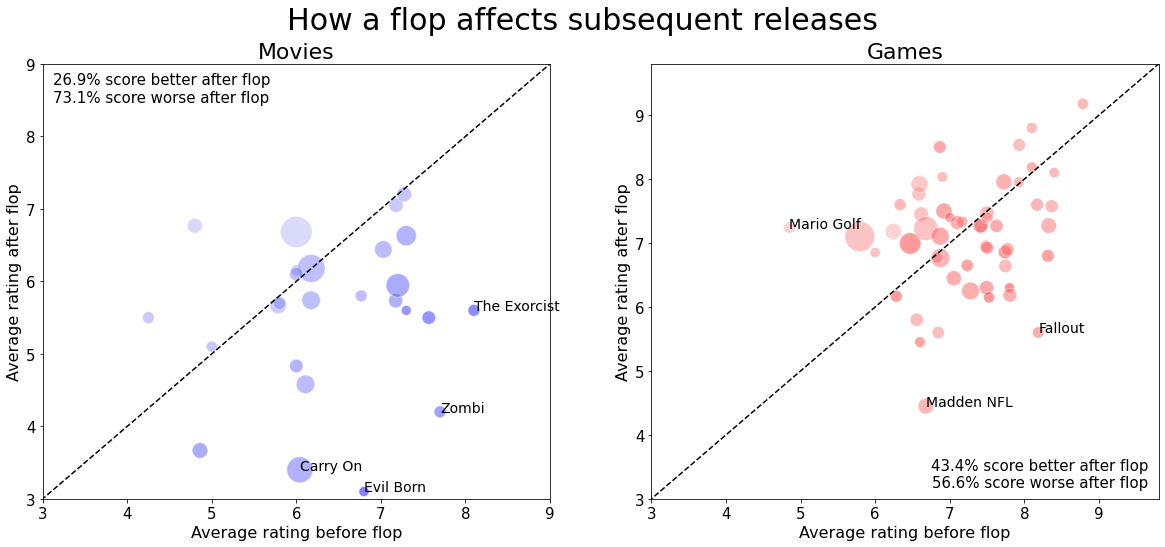

In [91]:
fig, axs = plt.subplots(ncols=2, figsize=(20, 8)) # create a figure with 2 columns of subplots

# plot movie data as blue scatter plot
sns.scatterplot(ax=axs[0], x=franchise_grouped_df_movie_flops['avg_pre_rating'], y=franchise_grouped_df_movie_flops['avg_post_rating'], size=franchise_grouped_df_movie_flops['releases_in_franchise'], color='blue', alpha=0.5, hue=franchise_grouped_df_movie_flops['diff_between_pre_and_lowest'], palette=sns.light_palette("blue", as_cmap=True), sizes=(100, 1000))
sns.scatterplot(ax=axs[1], x=franchise_grouped_df_game_flops['avg_pre_rating'], y=franchise_grouped_df_game_flops['avg_post_rating'], size=franchise_grouped_df_game_flops['releases_in_franchise'], color='blue', alpha=0.5, hue=franchise_grouped_df_game_flops['diff_between_pre_and_lowest'], palette=sns.light_palette("red", as_cmap=True), sizes=(100, 1000))

for i, row in franchise_grouped_df_movie_flops.iterrows():
    # Prevents error messages for ones that don't appear on the graph
    if (row['pos_in_fran_lowest_rated'] < 100) & (row['pos_in_fran_lowest_rated'] > 0):
        if abs(row['diff_pre_vs_post']) > 2.2:
            axs[0].text(row['avg_pre_rating'], row['avg_post_rating'], row['franchise_name'], fontsize=14)
for i, row in franchise_grouped_df_game_flops.iterrows():
    if (row['pos_in_fran_lowest_rated'] < 100) & (row['pos_in_fran_lowest_rated'] > 0):
          if abs(row['diff_pre_vs_post']) > 2.2:
                axs[1].text(row['avg_pre_rating'], row['avg_post_rating'], row['franchise_name'], fontsize=14)

                
# set the same diagonal line from the origin for both subplots
max_val = max(df['avg_pre_rating'].max(), df['avg_post_rating'].max())
axs[0].plot([0, max_val], [0, max_val], 'k--')
axs[1].plot([0, max_val], [0, max_val], 'k--')

# set the x and y axis labels for both subplots
fig.suptitle('How a flop affects subsequent releases', fontsize = 30)
axs[0].set_title('Movies', fontsize = 22)
axs[0].set_xlabel('Average rating before flop', fontsize = 16)
axs[0].set_ylabel('Average rating after flop', fontsize = 16)
axs[1].set_title('Games', fontsize = 22)
axs[1].set_xlabel('Average rating before flop', fontsize = 16)
axs[1].set_ylabel('Average rating after flop', fontsize = 16)
axs[0].tick_params(labelsize=15)
axs[1].tick_params(labelsize=15)

axs[0].set_xlim([3, 9])
axs[0].set_ylim([3, 9])
axs[1].set_xlim([3, max_val])
axs[1].set_ylim([3, max_val])

# calculate the percentage of points above and below the line for each subplot
movie_above_line = 100 * len(franchise_grouped_df_movie_flops[franchise_grouped_df_movie_flops['avg_post_rating'] > franchise_grouped_df_movie_flops['avg_pre_rating']]) / len(franchise_grouped_df_movie_flops.dropna())
game_above_line = 100 * len(franchise_grouped_df_game_flops[franchise_grouped_df_game_flops['avg_post_rating'] > franchise_grouped_df_game_flops['avg_pre_rating']]) / len(franchise_grouped_df_game_flops.dropna())
movie_below_line = 100 - movie_above_line
game_below_line = 100 - game_above_line

# add the percentage of points above and below the line to each subplot
axs[0].text(0.02, 0.98, f'{movie_above_line:.1f}% score better after flop\n{movie_below_line:.1f}% score worse after flop', transform=axs[0].transAxes, va='top', ha='left', fontsize=15)
axs[1].text(0.98, 0.02, f'{game_above_line:.1f}% score better after flop\n{game_below_line:.1f}% score worse after flop', transform=axs[1].transAxes, va='bottom', ha='right', fontsize=15)

# Modify the legend
axs[0].legend().remove()
axs[1].legend().remove()
#axs[0].legend(title='Smoker', loc='center left', labels=['Hell Yeh', 'Nah Bruh', 'HEY', 'WHAT', 'a', 'b', 'c', 'd'])

# show the plot
plt.show()


In [222]:
franchise_grouped_df_movie_flops.sort_values('releases_in_franchise', ascending = False).head(50)

,franchise_name,total_running_length_years,releases_in_franchise,content_type,avg_pre_rating,average_rating,lowest_rating,avg_post_rating,average_votes,lowest_rated_year,pos_in_fran_lowest_rated,diff_between_post_and_lowest,diff_between_pre_and_lowest,diff_pre_vs_post,diff_lowest_vs_avg
franchise_id,,,,,,,,,,,,,,,
f1336,Edgar Wallace Mysteries,14.0,47.0,movie,NaN,6.098291,4.20,6.335578,55.883081,1958.0,0.000000,2.135578,0.000000,NaN,1.898291
f1334,Charlie Chan,23.0,46.0,movie,6.000000,6.519167,4.80,6.681373,1060.250000,1929.0,13.636364,1.881373,1.200000,0.681373,1.719167
f1327,Godzilla,68.0,36.0,movie,6.175000,6.110294,3.90,6.178000,36838.926471,1969.0,22.388060,2.278000,2.275000,0.003000,2.210294
f1321,Carry On,35.0,31.0,movie,6.040833,5.791667,3.20,3.400000,3005.696970,1978.0,58.823529,0.200000,2.840833,-2.640833,2.591667
f69,Jetlag Productions' Children's Classics,21.0,30.0,movie,NaN,5.818333,3.90,5.946222,23472.179167,1985.0,0.000000,2.046222,0.000000,NaN,1.918333
f1302,Bulldog Drummond,48.0,25.0,movie,7.200000,5.905000,4.10,5.944231,437.583333,1925.0,6.382979,1.844231,3.100000,-1.255769,1.805000
f1322,Ultra Series,52.0,18.0,movie,7.300000,6.550000,4.60,6.630000,156.705882,1974.0,13.725490,2.030000,2.700000,-0.670000,1.950000
f51,Godzilla Shōwa era (1954–1975),22.0,15.0,movie,6.175000,5.857143,3.90,5.740000,7937.785714,1969.0,71.428571,1.840000,2.275000,-0.435000,1.957143
f64,Ring and Ju-On,22.0,15.0,movie,6.108333,5.270833,3.70,4.580000,10589.500000,2012.0,66.666667,0.880000,2.408333,-1.528333,1.570833


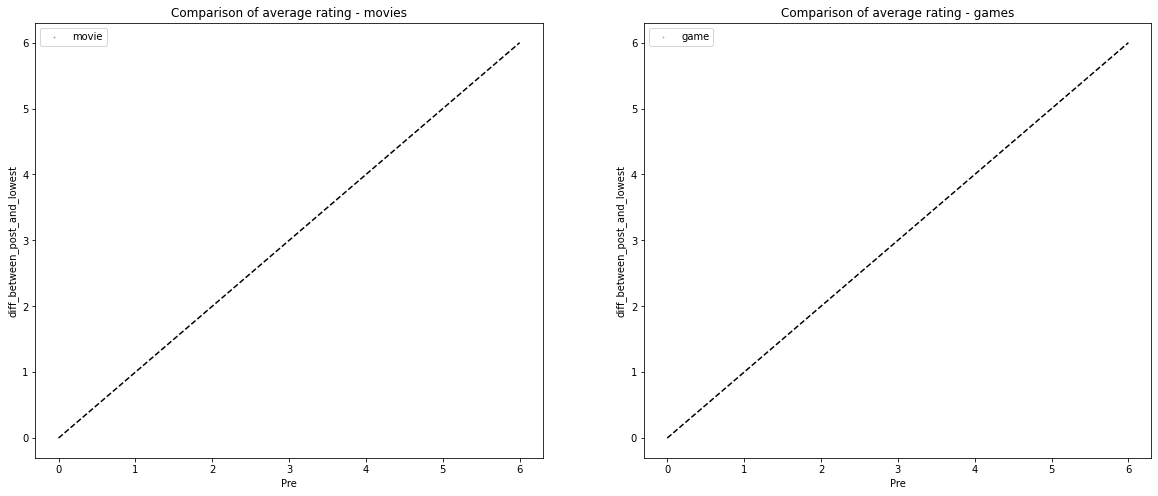

In [198]:
fig, axs = plt.subplots(ncols=2, figsize=(20, 8)) # create a figure with 2 columns of subplots

# create separate dataframes for movie and game content types
franchise_grouped_df_movie = franchise_grouped_df[(franchise_grouped_df['content_type'] == 'movie') & (franchise_grouped_df['diff_between_pre_and_lowest'] < -2)]
franchise_grouped_df_game = franchise_grouped_df[(franchise_grouped_df['content_type'] == 'game')  & (franchise_grouped_df['diff_between_pre_and_lowest'] < -2)]

# plot movie data as blue scatter plot
axs[0].scatter(x=-franchise_grouped_df_movie['diff_between_pre_and_lowest'], y=franchise_grouped_df_movie['diff_between_post_and_lowest'], s=franchise_grouped_df_movie['releases_in_franchise']*2, color='blue', label='movie', alpha=0.3)
#green_dot = franchise_grouped_df_movie_flops[franchise_grouped_df_movie_flops['franchise_name'] == 'Ice Age']
#sns.scatterplot(ax=axs[0], x=green_dot['avg_pre_rating'], y=green_dot['avg_post_rating'], color='green', s=500)
# plot game data as red scatter plot
axs[1].scatter(x=-franchise_grouped_df_game['diff_between_pre_and_lowest'], y=franchise_grouped_df_game['diff_between_post_and_lowest'], s=franchise_grouped_df_game['releases_in_franchise']*2, color='red', label='game', alpha=0.3)

# set the same diagonal line from the origin for both subplots
max_val = max(df['diff_between_pre_and_lowest'].max(), df['diff_between_post_and_lowest'].max())
axs[0].plot([0, max_val], [0, max_val], 'k--')
axs[1].plot([0, max_val], [0, max_val], 'k--')

# set the x and y axis labels for both subplots
axs[0].set_title('Comparison of average rating - movies')
axs[0].set_xlabel('Pre')
axs[0].set_ylabel('diff_between_post_and_lowest')
axs[1].set_title('Comparison of average rating - games')
axs[1].set_xlabel('Pre')
axs[1].set_ylabel('diff_between_post_and_lowest')

# set legend for both subplots
axs[0].legend()
axs[1].legend()

# show the plot
plt.show()


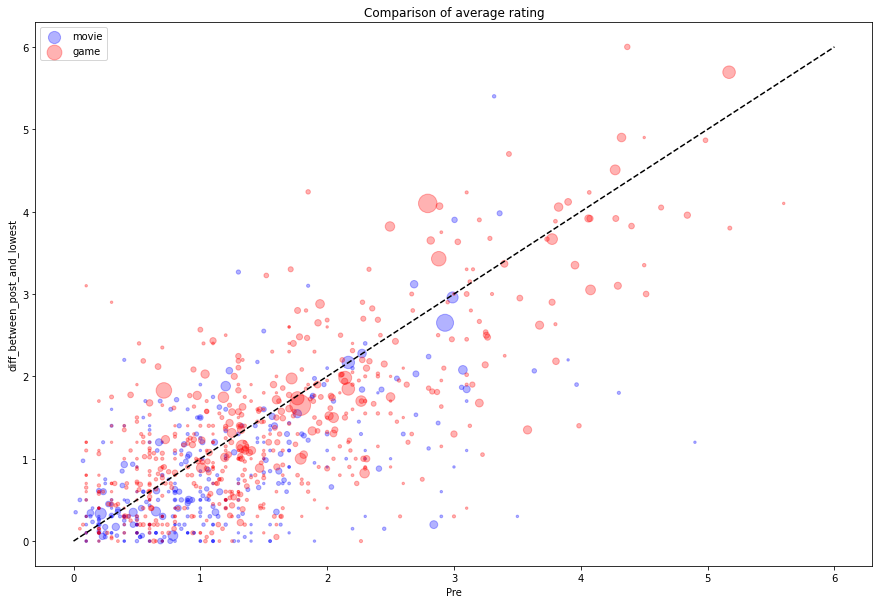

In [33]:
fig, ax = plt.subplots(figsize=(15, 10))

# plot movie data as blue scatter plot
plt.scatter(x = -franchise_grouped_df_movie['diff_between_pre_and_lowest'], y = franchise_grouped_df_movie['diff_between_post_and_lowest'], s=franchise_grouped_df_movie['releases_in_franchise']*2, color='blue', label='movie', alpha = 0.3,)

# plot game data as red scatter plot
plt.scatter(-franchise_grouped_df_game['diff_between_pre_and_lowest'], franchise_grouped_df_game['diff_between_post_and_lowest'], s=franchise_grouped_df_game['releases_in_franchise']*2, color='red', label='game', alpha = 0.3)

#plt.scatter(-franchise_grouped_df[franchise_grouped_df["franchise_name"] == 'Marvel']['diff_between_pre_and_lowest'], franchise_grouped_df[franchise_grouped_df["franchise_name"] == 'Marvel']['diff_between_post_and_lowest'], s=franchise_grouped_df['releases_in_franchise'], color='green')
# draw a diagonal line from the origin
max_val = max(df['diff_between_pre_and_lowest'].max(), df['diff_between_post_and_lowest'].max())
plt.plot([0, max_val], [0, max_val], 'k--')

# set the x and y axis labels
plt.title('Comparison of average rating')
plt.xlabel('Pre',)
plt.ylabel('diff_between_post_and_lowest')

# set legend
plt.legend()

# show the plot
plt.show()


In [34]:
franchise_grouped_df['average_year_gap_between_releases'] = franchise_grouped_df['total_running_length_years'] / franchise_grouped_df['releases_in_franchise']

<AxesSubplot:>

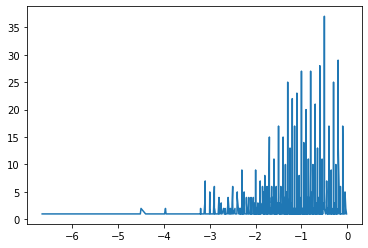

In [35]:
franchise_grouped_df.diff_between_pre_and_lowest.value_counts().sort_index().plot()

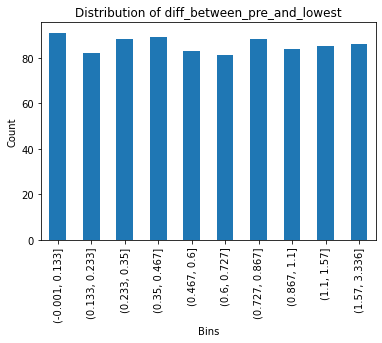

In [128]:
bins = pd.qcut(franchise_grouped_df_movie.diff_lowest_vs_avg, 10)

# Get the counts of values in each bin
counts = bins.value_counts().sort_index()

# Plot a histogram of the bin counts
counts.plot(kind='bar')
plt.xlabel('Bins')
plt.ylabel('Count')
plt.title('Distribution of diff_between_pre_and_lowest')
plt.show()

In [37]:
bins.value_counts().sort_index()

(-6.657, -1.75]    424
(-1.75, -1.1]      428
(-1.1, -0.6]       413
(-0.6, -0.0167]    422
Name: diff_between_pre_and_lowest, dtype: int64

The reason we are doing this is because we don't want to assume that a franchise that just gradually decreased in rating died as a result of their last release being a flop. This is why we are taking into account only those franchises where there was a significant drop below the average

In [38]:
franchise_grouped_df[(franchise_grouped_df['diff_between_pre_and_lowest']>-0.5)].content_type.value_counts()

movie    166
game     110
Name: content_type, dtype: int64

In [39]:
franchise_grouped_df[(franchise_grouped_df['diff_between_pre_and_lowest'] < -2) & (franchise_grouped_df['pos_in_fran_lowest_rated'] != 100)]

,franchise_name,total_running_length_years,releases_in_franchise,content_type,avg_pre_rating,average_rating,lowest_rating,avg_post_rating,average_votes,lowest_rated_year,pos_in_fran_lowest_rated,diff_between_post_and_lowest,diff_between_pre_and_lowest,average_year_gap_between_releases
franchise_id,,,,,,,,,,,,,,
3025-10,Tony Hawk,22,15.0,game,6.866667,6.671429,2.5,8.500000,601.107143,2015,76.190476,6.000000,-4.366667,1.466667
3025-1009,NBA Jam,18,5.0,game,8.200000,7.100000,5.1,7.000000,144.600000,1996,17.647059,1.900000,-3.100000,3.600000
3025-1020,Avatar: The Last Airbender,9,5.0,game,7.633333,6.940000,4.5,7.300000,417.800000,2010,50.000000,2.800000,-3.133333,1.800000
3025-1022,Forgotten Realms,26,25.0,game,7.492188,7.187500,3.2,6.300000,266.583333,2011,92.000000,3.100000,-4.292188,1.040000
3025-1023,Fist of the North Star,33,9.0,game,7.300000,6.500000,4.1,6.766667,35.500000,1987,3.125000,2.666667,-3.200000,3.666667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
f85,Debbie Does Dallas,11,6.0,movie,5.800000,5.300000,3.6,5.700000,629.300000,1981,30.000000,2.100000,-2.200000,1.833333
f865,Dhamaal,13,3.0,movie,7.400000,5.166667,3.9,4.200000,9496.333333,2011,33.333333,0.300000,-3.500000,4.333333
f882,Dumb and Dumber,21,3.0,movie,7.300000,5.433333,3.4,5.600000,191734.666667,2003,45.000000,2.200000,-3.900000,7.000000


In [116]:
df

,franchise_id,min_rating,max_rating,min_rating_x,max_rating_x,min_rating_y,max_rating_y,min_vote,max_vote,min_year,max_year,franchise_name,type,tconst,title,year,is_adult,runtime,genres,votes_average,rating_average,franchise_count,content_per_year,year_diff,vote_diff,rating_diff,num_of_releases_diff,z_rating,z_votes,position_in_franchise,pos_tens,year_value,lowest_scoring_year,pos_rel_to_flop,pos_rel_to_flop_year,lowest_rating_year,lowest_rated_year,pos_rel_to_lowest_year,avg_pre_rating,avg_post_rating,diff_between_pre_and_lowest
0,3025-1,3.00,8.9,3.00,8.9,3.00,8.9,13.0,6522.0,1978,2022,Mario,game,tt0315808,Baseball,1978,0,NaN,"["" 'Family'"", ""['Sport'"", "" 'Baseball'"", "" 'Sp...",13.0,3.00,195.0,1.0,NaN,NaN,NaN,NaN,-3.808490,-0.253646,0.000000,"(0.999, 1137.5]",NaN,1978,872,NaN,1978,1978,lowest,NaN,6.891227,NaN
1,3025-1,3.00,8.9,3.00,8.9,3.00,8.9,13.0,6522.0,1978,2022,Mario,game,tt0176664,Donkey Kong,1981,0,NaN,"["" 'Platformer']"", ""['Action'""]",2011.0,7.40,195.0,1.0,3.0,1998.0,4.40,0.0,0.278200,0.593586,6.818182,"(2274.0, 3410.5]",NaN,1978,872,NaN,1978,1978,post,NaN,6.891227,NaN
2,3025-1,3.00,8.9,3.00,8.9,3.00,8.9,13.0,6522.0,1978,2022,Mario,game,"tt0204287, tt3472820","Donkey Kong Junior, Donkey Kong",1982,0,NaN,"["" 'Family']"", "" 'Platformer'"", ""['Action'""]",170.5,6.50,195.0,2.0,1.0,-1840.5,-0.90,1.0,-0.557714,-0.186860,9.090909,"(2274.0, 3410.5]",NaN,1978,872,NaN,1978,1978,post,NaN,6.891227,NaN
3,3025-1,3.00,8.9,3.00,8.9,3.00,8.9,13.0,6522.0,1978,2022,Mario,game,"tt0176971, tt0185909, tt0302501, tt2318635, tt...","Mario Bros., Baseball, Donkey Kong, Pinball, M...",1983,0,NaN,"[""['Sport'"", "" 'Baseball'"", ""['\\\\N']"", "" 'Pi...",326.8,6.00,195.0,5.0,1.0,156.3,-0.50,3.0,-1.022110,-0.120583,11.363636,"(2274.0, 3410.5]",NaN,1978,872,NaN,1978,1978,post,NaN,6.891227,NaN
4,3025-1,3.00,8.9,3.00,8.9,3.00,8.9,13.0,6522.0,1978,2022,Mario,game,"tt0185017, tt0186168, tt3404206, tt3410580","Wrecking Crew, Golf, Mario Bros. Special, Punc...",1984,0,NaN,"["" 'Action'"", "" 'Sport'"", "" 'Platformer'"", ""['...",49.5,5.85,195.0,4.0,1.0,-277.3,-0.15,-1.0,-1.161429,-0.238169,13.636364,"(2274.0, 3410.5]",NaN,1978,872,NaN,1978,1978,post,NaN,6.891227,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11378,f993,6.40,7.0,6.40,7.0,6.40,7.0,99.0,658.0,1948,1952,Renato Castellani's Italian neorealism trilogy,movie,tt0040018,it's forever springtime,1950,0,92,"['Comedy', 'Drama']",99.0,6.40,3.0,1.0,2.0,-212.0,-0.50,0.0,0.334048,-0.330841,50.000000,"(5683.5, 6820.0]",NaN,1948,872,NaN,1948,1950,lowest,6.9,7.000000,-0.5
11379,f993,6.40,7.0,6.40,7.0,6.40,7.0,99.0,658.0,1948,1952,Renato Castellani's Italian neorealism trilogy,movie,tt0044572,two cents worth of hope,1952,0,110,"['Comedy', 'Romance']",658.0,7.00,3.0,1.0,2.0,559.0,0.60,0.0,0.854707,-0.327767,100.000000,"(10229.5, 11366.0]",NaN,1948,872,NaN,1948,1950,post,6.9,7.000000,-0.5
11380,f994,4.25,5.2,4.25,5.2,4.25,5.2,2068.0,5449.5,1974,1987,It's Alive,movie,"tt0071198, tt0071675","the bat people, it's alive",1974,0,93,"['Romance', 'Horror', 'Sci-Fi']",5449.5,4.25,4.0,2.0,NaN,NaN,NaN,NaN,-1.531648,-0.301416,0.000000,"(1137.5, 2274.0]",NaN,1974,872,NaN,1974,1974,lowest,NaN,5.000000,NaN
11381,f994,4.25,5.2,4.25,5.2,4.25,5.2,2068.0,5449.5,1974,1987,It's Alive,movie,tt0077756,it lives again,1978,0,91,"['Horror', 'Sci-Fi']",2494.0,5.20,4.0,1.0,4.0,-2955.5,0.95,-1.0,-0.707271,-0.317670,30.769231,"(3410.5, 4547.0]",NaN,1974,872,NaN,1974,1974,post,NaN,5.000000,NaN


In [40]:
movies = df[df['type'] == 'movie']
games = df[df['type'] == 'game']


<ipython-input-42-30c39bc6ff92>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movies['pos_tens'] = pd.qcut(movies['position_in_franchise'].rank(method='first'), q=10,)
<ipython-input-42-30c39bc6ff92>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  games['pos_tens'] = pd.qcut(games['position_in_franchise'].rank(method='first'), q=10,)


<AxesSubplot:xlabel='pos_tens'>

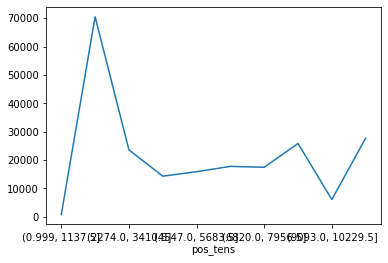

In [42]:
movies['pos_tens'] = pd.qcut(movies['position_in_franchise'].rank(method='first'), q=10,)
games['pos_tens'] = pd.qcut(games['position_in_franchise'].rank(method='first'), q=10,)
df['pos_tens'] = pd.qcut(df['position_in_franchise'].rank(method='first'), q=10,)

df.groupby('pos_tens')['votes_average'].mean().plot()


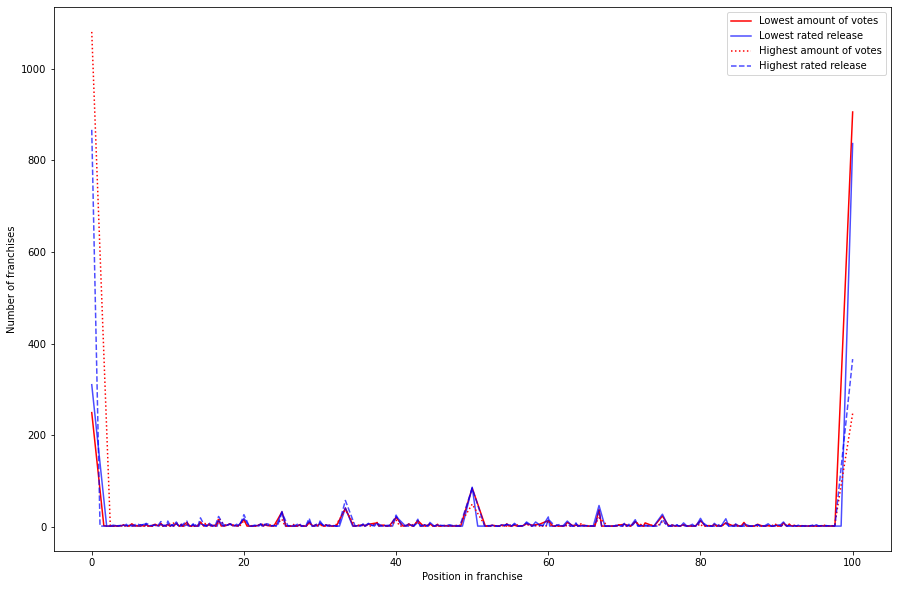

In [43]:
#franchise_grouped_df.groupby((franchise_grouped_df['average_releases_per_year'] // 0.1) * 0.1)['average_rating'].mean().plot()
#df[df["min_rating"] == df["rating_average"]].position_in_franchise.value_counts() // 0.1 * 0.1.sort_index().plot(color="blue", alpha =0.7, ax=ax, label = "Lowest rated release")

fig, ax = plt.subplots(figsize=(15, 10))
df[df["min_vote"] == df["votes_average"]].position_in_franchise.value_counts().sort_index().plot(xlabel="Position in franchise", ylabel="Number of franchises", color="red", ax=ax, label = "Lowest amount of votes")
df[df["min_rating"] == df["rating_average"]].position_in_franchise.value_counts().sort_index().plot(color="blue", alpha =0.7, ax=ax, label = "Lowest rated release")
df[df["max_vote"] == df["votes_average"]].position_in_franchise.value_counts().sort_index().plot(xlabel="Position in franchise", ylabel="Number of franchises", color="red", ax=ax, label = "Highest amount of votes", linestyle = ':')
df[df["max_rating"] == df["rating_average"]].position_in_franchise.value_counts().sort_index().plot(color="blue", alpha =0.7, ax=ax, label = "Highest rated release", linestyle = '--')

plt.legend()
plt.show()

In [44]:
games_df = df[df["type"] == "game"]
movies_df = df[df["type"] == "movie"]

In [45]:
movies_df

,franchise_id,min_rating,max_rating,min_vote,max_vote,min_year,max_year,franchise_name,type,tconst,title,year,is_adult,runtime,genres,votes_average,rating_average,franchise_count,content_per_year,year_diff,vote_diff,rating_diff,num_of_releases_diff,z_rating,z_votes,position_in_franchise,lowest_rated_year,lowest_rated_pos,pos_rel_to_lowest_year,avg_pre_rating,avg_post_rating,diff_between_pre_and_lowest,diff_between_post_and_lowest,rolling_mean,diff_from_rolling_mean,pos_tens
7305,f0,6.00,7.7,49.0,146.0,1939,1944,The Aldrich Family,movie,tt0032123,what a life,1939,0,75,"['Comedy', 'Drama']",93.000000,6.90,11.0,1.0,NaN,NaN,NaN,NaN,0.767931,-0.330874,0.000000,1940,20.0,pre,6.9,7.025,-0.9,1.025,6.900000,NaN,"(1137.5, 2274.0]"
7306,f0,6.00,7.7,49.0,146.0,1939,1944,The Aldrich Family,movie,tt0033834,life with henry,1940,0,80,"['Comedy', 'Family', 'Music']",49.000000,6.00,11.0,1.0,1.0,-44.000000,-0.90,0.0,-0.013058,-0.331116,20.000000,1940,20.0,lowest,6.9,7.025,-0.9,1.025,6.450000,-0.450000,"(3410.5, 4547.0]"
7307,f0,6.00,7.7,49.0,146.0,1939,1944,The Aldrich Family,movie,tt0033708,henry aldrich for president,1941,0,75,"['Comedy', 'Family']",146.000000,6.60,11.0,1.0,1.0,97.000000,0.60,0.0,0.507601,-0.330582,40.000000,1940,20.0,post,6.9,7.025,-0.9,1.025,6.500000,0.050000,"(4547.0, 5683.5]"
7308,f0,6.00,7.7,49.0,146.0,1939,1944,The Aldrich Family,movie,"tt0034842, tt0034844","henry aldrich, editor, henry and dizzy",1942,0,72,"['Comedy', 'Family', 'Drama']",104.000000,6.80,11.0,2.0,1.0,-42.000000,0.20,1.0,0.681154,-0.330813,60.000000,1940,20.0,post,6.9,7.025,-0.9,1.025,6.575000,0.075000,"(6820.0, 7956.5]"
7309,f0,6.00,7.7,49.0,146.0,1939,1944,The Aldrich Family,movie,"tt0035985, tt0035983, tt0035984","henry aldrich swings it, henry aldrich gets gl...",1943,0,64,"['Comedy', 'Family', 'Adventure']",130.333333,7.00,11.0,3.0,1.0,26.333333,0.20,1.0,0.854707,-0.330669,80.000000,1940,20.0,post,6.9,7.025,-0.9,1.025,6.660000,0.085000,"(7956.5, 9093.0]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11378,f993,6.40,7.0,99.0,658.0,1948,1952,Renato Castellani's Italian neorealism trilogy,movie,tt0040018,it's forever springtime,1950,0,92,"['Comedy', 'Drama']",99.000000,6.40,3.0,1.0,2.0,-212.000000,-0.50,0.0,0.334048,-0.330841,50.000000,1950,50.0,lowest,6.9,7.000,-0.5,0.600,6.650000,-0.250000,"(5683.5, 6820.0]"
11379,f993,6.40,7.0,99.0,658.0,1948,1952,Renato Castellani's Italian neorealism trilogy,movie,tt0044572,two cents worth of hope,1952,0,110,"['Comedy', 'Romance']",658.000000,7.00,3.0,1.0,2.0,559.000000,0.60,0.0,0.854707,-0.327767,100.000000,1950,50.0,post,6.9,7.000,-0.5,0.600,6.766667,0.116667,"(10229.5, 11366.0]"
11380,f994,4.25,5.2,2068.0,5449.5,1974,1987,It's Alive,movie,"tt0071198, tt0071675","the bat people, it's alive",1974,0,93,"['Romance', 'Horror', 'Sci-Fi']",5449.500000,4.25,4.0,2.0,NaN,NaN,NaN,NaN,-1.531648,-0.301416,0.000000,1974,0.0,lowest,NaN,5.000,NaN,0.750,4.250000,NaN,"(1137.5, 2274.0]"
11381,f994,4.25,5.2,2068.0,5449.5,1974,1987,It's Alive,movie,tt0077756,it lives again,1978,0,91,"['Horror', 'Sci-Fi']",2494.000000,5.20,4.0,1.0,4.0,-2955.500000,0.95,-1.0,-0.707271,-0.317670,30.769231,1974,0.0,post,NaN,5.000,NaN,0.750,4.725000,0.475000,"(3410.5, 4547.0]"


- Define a flop
- Normalise rating diff to see what the biggest drop offs are across both media
- Graph results and use it to define a reasonable threshold for a flop
- stacked bar chart for games and movies showing % of flops that "recovered"\
&nbsp; ie if the content that flopped was the last in the series\
&nbsp; (may need to filter out content that was released in the last year or 2)


In [23]:
games_df.loc[games_df.franchise_name.isin(movies_df.franchise_name),'match']=True

C:\Users\35387\AppData\Local\Temp\ipykernel_106852\3994652624.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  games_df.loc[games_df.franchise_name.isin(movies_df.franchise_name),'match']=True


In [30]:
games_df[pd.notnull(games_df["match"])]["franchise_name"].unique()

array(['Commando', 'Peanuts', 'Lucky Luke', 'The Godfather', 'X-Men',
       'Pirates of the Caribbean', 'Dead or Alive', 'Cars', 'Die Hard',
       'Madagascar', 'Starship Troopers', 'The Punisher',
       'FIFA World Cup', 'Blair Witch', 'Kung Fu Panda', 'Ice Age',
       'Godzilla', 'Winnie the Pooh', 'Transformers', 'Despicable Me',
       'Tom and Jerry', 'Drift', 'Terminator', 'Alvin and the Chipmunks',
       'Star Trek', 'SpongeBob SquarePants', 'Indiana Jones', 'Shrek',
       'James Bond', 'Jaws', 'Jurassic Park', 'Rocky', 'RoboCop',
       'Resident Evil', 'Rambo', 'Jumanji', 'Back to the Future',
       'Pokémon', 'One Piece', 'The Lord of the Rings', 'Mickey Mouse',
       'Mission: Impossible', 'Star Wars', 'Spider-Man', 'Sailor Moon',
       'Evil Dead', 'Ghostbusters', 'The Matrix', 'Home Alone',
       'Mortal Kombat', 'Bleach', 'Nancy Drew', 'Blood', 'Toy Story',
       'Digimon', 'Barbie', 'The Flintstones', 'Monty Python',
       'Men in Black', 'Asterix'], dtype=ob

As discussed on Friday it will be interesting to see how you define a "flop" and explore the recovery or otherwise after a flop. try to keep it simple reasonable. If you decide, for example, that a flop is a movie/game that has x% fewer ratings/votes that the preceding title then that's fine as long as you can defend x. You can also write you analysis code in such a way as to make it easy to change x so that you can do a "sensitivity analysis" by varying x. If you find that the outcome is similar for various ranges of x then that's a good sign.
